In [1]:
# Cell 1
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#2: Import libraries

# Core
import pandas as pd
import numpy as np
import seaborn as sns


# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Utility
import joblib
import warnings
warnings.filterwarnings('ignore')




In [3]:
#3: Load preprocessed NSL-KDD split data
# FIX: Use consistent project path
nsl_path = "/content/drive/MyDrive/NIDS_Project/NIDS_Data/NSL_KDD"

scaler = joblib.load(f"{nsl_path}/nslkdd_scaler.pkl")
X_train = pd.read_csv(f"{nsl_path}/nslkdd_X_train.csv")
X_test  = pd.read_csv(f"{nsl_path}/nslkdd_X_test.csv")
y_train = pd.read_csv(f"{nsl_path}/nslkdd_y_train.csv")
y_test  = pd.read_csv(f"{nsl_path}/nslkdd_y_test.csv")

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (88180, 41) (88180, 1)
Test shape: (37792, 41) (37792, 1)


In [4]:
#4: Check target class distribution
print("Training labels:\n", y_train.value_counts())
print("Testing labels:\n", y_test.value_counts())

Training labels:
 label
0        47328
1        40852
Name: count, dtype: int64
Testing labels:
 label
0        20014
1        17778
Name: count, dtype: int64


In [5]:
#5: Create a reusable model evaluation function
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n{name} Accuracy: {acc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [6]:
#6: Train Random Forest with cross-validation
from sklearn.model_selection import cross_val_score

rf_model = RandomForestClassifier(random_state=42)
cv_scores = cross_val_score(rf_model, X_train, y_train.values.ravel(), cv=5, scoring='accuracy')

print("Random Forest Cross-Val Accuracy Scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())

Random Forest Cross-Val Accuracy Scores: [0.99897936 0.99829893 0.99897936 0.99835564 0.99863915]
Mean Accuracy: 0.9986504876389203



Logistic Regression Accuracy: 0.9529

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96     20014
           1       0.96      0.94      0.95     17778

    accuracy                           0.95     37792
   macro avg       0.95      0.95      0.95     37792
weighted avg       0.95      0.95      0.95     37792



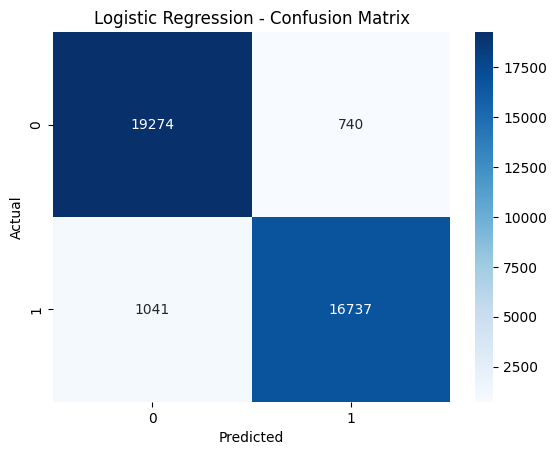

In [7]:
#7: Train and evaluate Logistic Regression
log_model = LogisticRegression(max_iter=200, random_state=42)
log_model.fit(X_train, y_train)

evaluate_model("Logistic Regression", log_model, X_test, y_test)


K-Nearest Neighbors Accuracy: 0.9954

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20014
           1       1.00      1.00      1.00     17778

    accuracy                           1.00     37792
   macro avg       1.00      1.00      1.00     37792
weighted avg       1.00      1.00      1.00     37792



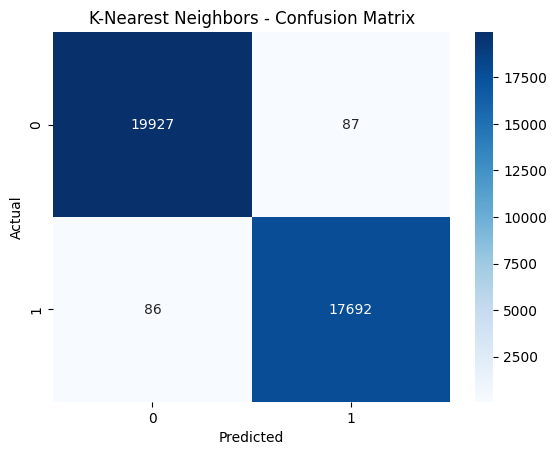

In [8]:
#8: Train and evaluate K-Nearest Neighbors
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train.values.ravel())

evaluate_model("K-Nearest Neighbors", knn_model, X_test, y_test)

In [9]:
#9: Train and evaluate MLP Neural Network
mlp_model = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=300, random_state=42)
mlp_model.fit(X_train, y_train.values.ravel())

evaluate_model("MLP Neural Network", mlp_model, X_test, y_test)


MLP Neural Network Accuracy: 0.9965

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20014
           1       1.00      1.00      1.00     17778

    accuracy                           1.00     37792
   macro avg       1.00      1.00      1.00     37792
weighted avg       1.00      1.00      1.00     37792



In [10]:
#10: Compare model performance in a summary table
# FIX: Avoid retraining inside dictionary
results = {
    "Random Forest": cv_scores.mean(),  # From cross-validation in #6
    "Logistic Regression": log_model.score(X_test, y_test),
    "K-Nearest Neighbors": knn_model.score(X_test, y_test),
    "MLP Neural Network": mlp_model.score(X_test, y_test)
}

In [11]:
#11: Visualize Random Forest Feature Importance
rf_model_final = RandomForestClassifier(random_state=42)
rf_model_final.fit(X_train, y_train.values.ravel())

importances = rf_model_final.feature_importances_
feature_names = X_train.columns

feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')
plt.title('Top 15 Important Features (Random Forest)')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


Training MLP with hidden layers: (32,)

Training MLP with hidden layers: (64, 32)

Training MLP with hidden layers: (128, 64, 32)


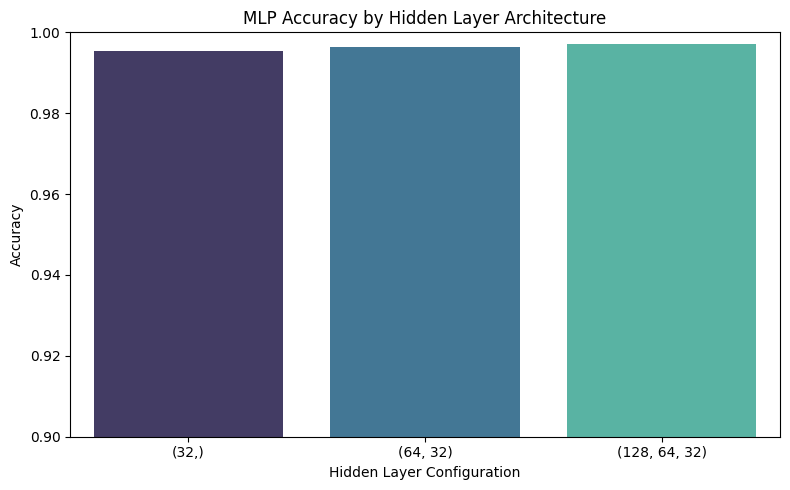

In [12]:
#12: MLP Neural Network with Hidden Layer Tuning
hidden_layer_configs = [(32,), (64, 32), (128, 64, 32)]
mlp_results = []

for config in hidden_layer_configs:
    print(f"\nTraining MLP with hidden layers: {config}")
    mlp_model = MLPClassifier(hidden_layer_sizes=config, max_iter=300, random_state=42)
    mlp_model.fit(X_train, y_train.values.ravel())
    acc = mlp_model.score(X_test, y_test)
    mlp_results.append((str(config), acc))

# Plot MLP architecture results
mlp_results_df = pd.DataFrame(mlp_results, columns=['Architecture', 'Accuracy'])
plt.figure(figsize=(8,5))
sns.barplot(data=mlp_results_df, x='Architecture', y='Accuracy', palette='mako')
plt.ylim(0.90, 1.00)
plt.title('MLP Accuracy by Hidden Layer Architecture')
plt.xlabel('Hidden Layer Configuration')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

In [13]:
#13: KNN with different k-values
k_values = [3, 5, 7, 9]
knn_results = []

for k in k_values:
    print(f"\nTraining KNN with k={k}")
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train.values.ravel())
    acc = accuracy_score(y_test, knn_model.predict(X_test))
    knn_results.append((k, acc))

# Plot KNN results
knn_df = pd.DataFrame(knn_results, columns=['k', 'Accuracy'])
plt.figure(figsize=(8,5))
sns.lineplot(data=knn_df, x='k', y='Accuracy', marker='o', linewidth=2)
plt.ylim(0.90, 1.00)
plt.title('KNN Accuracy for Different k Values')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.tight_layout()
plt.show()


Training KNN with k=3

Training KNN with k=5

Training KNN with k=7

Training KNN with k=9


In [14]:
#14: Hyperparameter tuning Random Forest using GridSearchCV
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train.values.ravel())

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Evaluate tuned model
best_rf_model = grid_search.best_estimator_
evaluate_model("Tuned Random Forest", best_rf_model, X_test, y_test)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Validation Accuracy: 0.9985711041726769

Tuned Random Forest Accuracy: 0.9990

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20014
           1       1.00      1.00      1.00     17778

    accuracy                           1.00     37792
   macro avg       1.00      1.00      1.00     37792
weighted avg       1.00      1.00      1.00     37792



In [15]:
#15: Export best model
joblib.dump(best_rf_model, '/content/drive/MyDrive/NIDS_Project/NIDS_Data/NSL_KDD/best_rf_model.pkl')
print("Tuned Random Forest model saved as 'best_rf_model.pkl'")

Tuned Random Forest model saved as 'best_rf_model.pkl'


# UNSW

In [16]:
#1: Load preprocessed data and scaler
# Load cleaned and preprocessed data for modeling UNSW-NB15

import numpy as np
import pickle
import joblib

# Load the final, preprocessed, encoded, and scaled arrays
X_train_final = np.load("/content/drive/MyDrive/NIDS_Project/NIDS_Data/UNSW_NB15/unsw_X_train_final.npy")
X_test_final  = np.load("/content/drive/MyDrive/NIDS_Project/NIDS_Data/UNSW_NB15/unsw_X_test_final.npy")
y_train_final = np.load("/content/drive/MyDrive/NIDS_Project/NIDS_Data/UNSW_NB15/unsw_y_train_final.npy")
y_test_final  = np.load("/content/drive/MyDrive/NIDS_Project/NIDS_Data/UNSW_NB15/unsw_y_test_final.npy")

# For SHAP plots
with open("/content/drive/MyDrive/NIDS_Project/NIDS_Data/UNSW_NB15/unsw_feature_names.pkl", "rb") as f:
    feature_names = pickle.load(f)

# Load the fitted scaler (corrected path)
unsw_scaler = joblib.load("/content/drive/MyDrive/NIDS_Project/NIDS_Data/UNSW_NB15/unsw_scaler.pkl")

# Check loaded shapes to confirm readiness
print("Loaded training set shape:", X_train_final.shape, y_train_final.shape)
print("Loaded testing set shape:", X_test_final.shape, y_test_final.shape)


Loaded training set shape: (175341, 34) (175341,)
Loaded testing set shape: (82332, 34) (82332,)


In [17]:
#16.1 Apply SMOTE to address class imbalance (only on training set)
from imblearn.over_sampling import SMOTE

print("Before SMOTE:", np.bincount(y_train_final))

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_final, y_train_final = smote.fit_resample(X_train_final, y_train_final)

print("After SMOTE:", np.bincount(y_train_final))

Before SMOTE: [ 56000 119341]
After SMOTE: [119341 119341]


In [18]:
print("X_test_final shape:", X_test_final.shape)
print("y_test_final shape:", y_test_final.shape)

X_test_final shape: (82332, 34)
y_test_final shape: (82332,)


In [19]:
# Flatten test labels if needed (some loads return shape (n,1))
if len(y_test_final.shape) > 1:
    y_test_final = y_test_final.ravel()

In [20]:
# Ensure X and y match in shape for prediction
X_test_final = X_test_final[:y_test_final.shape[0]]

In [21]:
if len(y_train_final.shape) > 1:
    y_train_final = y_train_final.ravel()

In [22]:
#18 Train and evaluate a baseline binary classifier
# Assumes y_train_final and y_test_final are already binary (0 = Normal, 1 = Attack)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

# Confirm class distributions
print("Train label distribution:", np.bincount(y_train_final))
print("Test label distribution:", np.bincount(y_test_final))

# Initialize model
baseline_model = LogisticRegression(solver='liblinear', random_state=42)

# Train
baseline_model.fit(X_train_final, y_train_final)

# Predict
y_pred_baseline = baseline_model.predict(X_test_final)

# Evaluate
print("=== Baseline Logistic Regression Report ===")
print("Accuracy:", accuracy_score(y_test_final, y_pred_baseline))
print("\nClassification Report:\n", classification_report(y_test_final, y_pred_baseline))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_final, y_pred_baseline))

Train label distribution: [119341 119341]
Test label distribution: [37000 45332]
=== Baseline Logistic Regression Report ===
Accuracy: 0.7673444104357965

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.89      0.78     37000
           1       0.88      0.67      0.76     45332

    accuracy                           0.77     82332
   macro avg       0.78      0.78      0.77     82332
weighted avg       0.79      0.77      0.77     82332


Confusion Matrix:
 [[33020  3980]
 [15175 30157]]


In [23]:
#19: Train and evaluate Random Forest classifier on balanced data
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Train model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_final, y_train_final)

# Predict
y_pred_rf = rf_model.predict(X_test_final)

# Evaluate
print("=== Random Forest Classifier Report (SMOTE Applied) ===")
print("Accuracy:", accuracy_score(y_test_final, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test_final, y_pred_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_final, y_pred_rf))

=== Random Forest Classifier Report (SMOTE Applied) ===
Accuracy: 0.8856945051741728

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.80      0.86     37000
           1       0.86      0.95      0.90     45332

    accuracy                           0.89     82332
   macro avg       0.89      0.88      0.88     82332
weighted avg       0.89      0.89      0.88     82332


Confusion Matrix:
 [[29692  7308]
 [ 2103 43229]]


In [24]:
#20: Train and evaluate XGBoost classifier on balanced data
from xgboost import XGBClassifier

xgb_model = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1,
                          use_label_encoder=False, eval_metric='logloss', random_state=42)

xgb_model.fit(X_train_final, y_train_final)
y_pred_xgb = xgb_model.predict(X_test_final)

print("=== XGBoost Classifier Report (SMOTE Applied) ===")
print("Accuracy:", accuracy_score(y_test_final, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test_final, y_pred_xgb))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_final, y_pred_xgb))

=== XGBoost Classifier Report (SMOTE Applied) ===
Accuracy: 0.9147233153573338

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91     37000
           1       0.95      0.89      0.92     45332

    accuracy                           0.91     82332
   macro avg       0.91      0.92      0.91     82332
weighted avg       0.92      0.91      0.91     82332


Confusion Matrix:
 [[34946  2054]
 [ 4967 40365]]


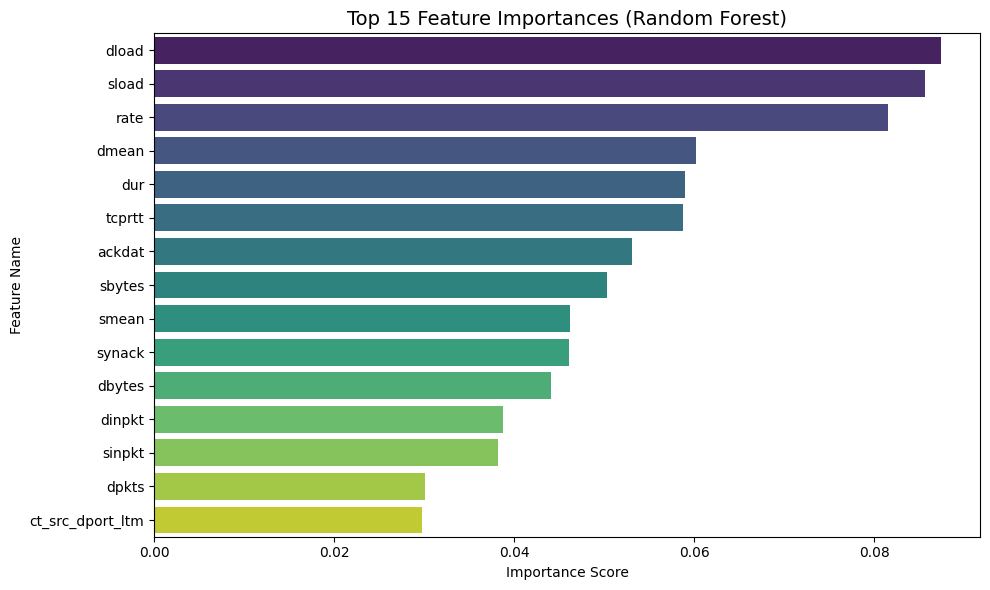

In [25]:
#21 Analyze feature importance
# Understanding which features the model relies on

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Retrieve feature importances from the trained Random Forest model
feature_importances = rf_model.feature_importances_

# Use the loaded feature_names from preprocessing
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort and visualize the top features
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(15), x='Importance', y='Feature', palette='viridis')
plt.title('Top 15 Feature Importances (Random Forest)', fontsize=14)
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.tight_layout()
plt.show()

In [26]:
#22: Compare model performances using real predictions
from sklearn.metrics import precision_score, recall_score, f1_score

metrics = {
    "Model": ["Logistic Regression", "Random Forest", "XGBoost"],
    "Accuracy": [accuracy_score(y_test_final, y_pred_baseline),
                 accuracy_score(y_test_final, y_pred_rf),
                 accuracy_score(y_test_final, y_pred_xgb)],
    "Precision": [precision_score(y_test_final, y_pred_baseline),
                  precision_score(y_test_final, y_pred_rf),
                  precision_score(y_test_final, y_pred_xgb)],
    "Recall": [recall_score(y_test_final, y_pred_baseline),
               recall_score(y_test_final, y_pred_rf),
               recall_score(y_test_final, y_pred_xgb)],
    "F1-Score": [f1_score(y_test_final, y_pred_baseline),
                 f1_score(y_test_final, y_pred_rf),
                 f1_score(y_test_final, y_pred_xgb)]
}


In [27]:
#23 Save final model and scaler (Seminar: Deployment-Ready Outputs)
# Preserve the trained model and its corresponding scaler for future use
import joblib

# Save the trained Random Forest model (best performer in benchmark comparison)
joblib.dump(rf_model, "/content/drive/MyDrive/NIDS_Project/NIDS_Data/UNSW_NB15/final_rf_model.pkl")

# Save the fitted MinMax scaler (used during preprocessing to ensure consistency at inference time)
joblib.dump(unsw_scaler, "/content/drive/MyDrive/NIDS_Project/NIDS_Data/UNSW_NB15/final_scaler.pkl")

# Confirmation message
print("Model and scaler successfully saved. Files ready for deployment or further evaluation.")


Model and scaler successfully saved. Files ready for deployment or further evaluation.


In [28]:
# Step 8: Interpret model predictions using SHAP (Named Features, Fixed and Accurate)

import shap
import joblib
import numpy as np
import matplotlib.pyplot as plt
import gc
import pickle
import pandas as pd

# Clear memory
gc.collect()

# Load model and data
rf_model = joblib.load("/content/drive/MyDrive/NIDS_Project/NIDS_Data/UNSW_NB15/final_rf_model.pkl")
X_test_final = np.load("/content/drive/MyDrive/NIDS_Project/NIDS_Data/UNSW_NB15/unsw_X_test_final.npy")

# Load feature names
with open("/content/drive/MyDrive/NIDS_Project/NIDS_Data/UNSW_NB15/unsw_feature_names.pkl", "rb") as f:
    feature_names = pickle.load(f)

# Create SHAP explainer
explainer = shap.TreeExplainer(rf_model)

# Select sample subset
X_sample = X_test_final[:1000]

# Compute SHAP values
shap_values = explainer.shap_values(X_sample)

# For binary classifier, shap_values is a list: [class_0_values, class_1_values]
if isinstance(shap_values, list):
    shap_values_plot = shap_values[1]  # Class 1 (attack)
else:
    shap_values_plot = shap_values  # single class output

# Create SHAP summary beeswarm plot
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values_plot, features=X_sample, feature_names=feature_names, plot_type="dot", show=False)
plt.title("SHAP Feature Importance (Beeswarm Plot) — Class 1: Attack")
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

In [29]:
# 24.1: Compact SHAP instance-level explainability
instance_index = 0
X_instance = X_test_final[instance_index:instance_index + 1]
shap_values = explainer.shap_values(X_instance)
shap_vals_instance = shap_values[1][0] if isinstance(shap_values, list) else shap_values[0][0]

# Flatten input for readable value indexing
X_flat = X_instance.flatten()

# Get top contributing feature indices
top_indices = np.argsort(np.abs(shap_vals_instance))[::-1][:5]

print(f"\nExplaining instance {instance_index} (Prediction = {rf_model.predict(X_instance)[0]})")
print("Top 5 SHAP Feature Contributions:")

for i in top_indices:
    print(f"{feature_names[i]}: {X_flat[i]:.4f} → SHAP = {shap_vals_instance[i]:.4f}")


Explaining instance 0 (Prediction = 1)
Top 5 SHAP Feature Contributions:
dur: 0.0000 → SHAP = -0.0405
proto: 0.0000 → SHAP = 0.0405


In [30]:
#32
print("X_instance shape:", X_instance.shape)
print("X_instance[0] shape:", X_instance[0].shape)

X_instance shape: (1, 34)
X_instance[0] shape: (34,)


In [31]:
import numpy as np

# Paths
x_test_path = "/content/drive/MyDrive/NIDS_Project/NIDS_Data/UNSW_NB15/unsw_X_test_final.npy"
y_test_path = "/content/drive/MyDrive/NIDS_Project/NIDS_Data/UNSW_NB15/unsw_y_test_final.npy"

# Load
X_test_final = np.load(x_test_path)
y_test_final = np.load(y_test_path)

# Flatten if needed
if len(y_test_final.shape) > 1:
    y_test_final = y_test_final.ravel()

print("X_test_final shape:", X_test_final.shape)
print("y_test_final shape:", y_test_final.shape)

X_test_final shape: (82332, 34)
y_test_final shape: (82332,)


In [32]:
#Reload the CORRECT test labels matching X_test_final for UNSW
y_test_final = np.load("/content/drive/MyDrive/NIDS_Project/NIDS_Data/UNSW_NB15/unsw_y_test_final.npy")
#Confirm alignment
print("X_test_final shape:", X_test_final.shape)
print("y_test_final shape:", y_test_final.shape)

# Run permutation importance
from sklearn.inspection import permutation_importance

perm_result = permutation_importance(
    rf_model,
    X_test_final,
    y_test_final,
    n_repeats=10,
    random_state=42,
    scoring='accuracy'
)

# ✅ Display top features
importances = perm_result.importances_mean
indices = np.argsort(importances)[::-1][:10]

print("\nTop 10 Feature Importances (Permutation):")
for rank, idx in enumerate(indices):
    print(f"#{rank+1}: Feature {idx} - Importance = {importances[idx]:.4f}")

X_test_final shape: (82332, 34)
y_test_final shape: (82332,)

Top 10 Feature Importances (Permutation):
#1: Feature 6 - Importance = 0.0280
#2: Feature 22 - Importance = 0.0257
#3: Feature 21 - Importance = 0.0255
#4: Feature 2 - Importance = 0.0231
#5: Feature 24 - Importance = 0.0194
#6: Feature 14 - Importance = 0.0144
#7: Feature 23 - Importance = 0.0132
#8: Feature 27 - Importance = 0.0120
#9: Feature 16 - Importance = 0.0104
#10: Feature 13 - Importance = 0.0074


In [33]:
#34 Save trained Random Forest model and SHAP explainer for reuse

import joblib
import shap

# Define persistent storage paths
model_path = "/content/drive/MyDrive/NIDS_Project/NIDS_Data/UNSW_NB15/final_rf_model.pkl"
explainer_path = "/content/drive/MyDrive/NIDS_Project/NIDS_Data/UNSW_NB15/final_shap_explainer.pkl"

# Save the final trained Random Forest model to disk
joblib.dump(rf_model, model_path)

# Create SHAP explainer using TreeExplainer and save to disk
explainer = shap.TreeExplainer(rf_model)
joblib.dump(explainer, explainer_path)

# Confirm successful export
print("Model and SHAP explainer saved.")


Model and SHAP explainer saved.


In [34]:
#35 Reload trained model and SHAP explainer for downstream use
import shap
import joblib
import numpy as np

# Define saved artifact paths (same as Step 11)
model_path = "/content/drive/MyDrive/NIDS_Project/NIDS_Data/UNSW_NB15/final_rf_model.pkl"
explainer_path = "/content/drive/MyDrive/NIDS_Project/NIDS_Data/UNSW_NB15/final_shap_explainer.pkl"

# Load Random Forest model and SHAP explainer from disk
rf_model = joblib.load(model_path)
explainer = joblib.load(explainer_path)

# Confirm successful loading of artifacts
print("Model and SHAP explainer successfully reloaded.")

Model and SHAP explainer successfully reloaded.


In [35]:
#36 Confirm prediction and explanation pipeline using reloaded artifacts
#Validate final outputs using reloaded model and SHAP explainer

import joblib
import numpy as np

# Reload model and SHAP explainer
model_path = "/content/drive/MyDrive/NIDS_Project/NIDS_Data/UNSW_NB15/final_rf_model.pkl"
explainer_path = "/content/drive/MyDrive/NIDS_Project/NIDS_Data/UNSW_NB15/final_shap_explainer.pkl"

reloaded_model = joblib.load(model_path)
reloaded_explainer = joblib.load(explainer_path)

# Choose test instance
instance_index = 0
X_instance = X_test_final[instance_index:instance_index + 1]
X_instance_flat = X_instance.flatten()

# Predict with reloaded model
pred_class = reloaded_model.predict(X_instance)[0]
proba_class1 = reloaded_model.predict_proba(X_instance)[0][1]

# Explain with reloaded explainer
shap_values = reloaded_explainer.shap_values(X_instance)

# Extract class 1 SHAP values
if isinstance(shap_values, list):
    shap_vals_instance = shap_values[1][0]  # Class 1
else:
    shap_vals_instance = shap_values[0]

# Handle shape (in case it's 2D)
if len(shap_vals_instance.shape) > 1:
    shap_vals_instance = shap_vals_instance[:, 1]

# Print verification output
print(f"Reloaded model prediction: Class {pred_class} (Attack probability = {proba_class1:.4f})")
print(f"Top 5 SHAP Feature Contributions (Reloaded Explainer):")

# Show top 5 SHAP features
top_indices = np.argsort(np.abs(shap_vals_instance))[::-1][:5]
for idx in top_indices:
    val = X_instance_flat[idx]
    shap_val = shap_vals_instance[idx]
    print(f"Feature {idx}: Value = {val:.4f}, SHAP = {shap_val:.4f}")


Reloaded model prediction: Class 1 (Attack probability = 0.8400)
Top 5 SHAP Feature Contributions (Reloaded Explainer):
Feature 1: Value = 0.0000, SHAP = -0.0800
Feature 9: Value = 0.0301, SHAP = 0.0575
Feature 28: Value = 0.0000, SHAP = 0.0515
Feature 7: Value = 0.0000, SHAP = 0.0510
Feature 10: Value = 0.0000, SHAP = 0.0467


In [36]:
#38 Map Feature Indices to Original Column Names for SHAP Output

# Use the feature_names loaded from preprocessing
named_explanation = []
for idx in top_indices:
    feat_name = feature_names[idx]
    feat_val = X_instance_flat[idx]
    shap_val = shap_vals_instance[idx]
    named_explanation.append((feat_name, feat_val, shap_val))

# Display final explanation table
df_named = pd.DataFrame(named_explanation, columns=["Feature Name", "Value", "SHAP Contribution"])
print(f"Prediction: Class {pred_class} (Attack probability = {proba_class1:.4f})")
print("\nTop 5 SHAP Feature Contributions (Named):")
print(df_named)

Prediction: Class 1 (Attack probability = 0.8400)

Top 5 SHAP Feature Contributions (Named):
       Feature Name     Value  SHAP Contribution
0             proto  0.000000          -0.080004
1             sload  0.030121           0.057512
2  ct_src_dport_ltm  0.000000           0.051476
3            dbytes  0.000000           0.051035
4             dload  0.000000           0.046712


In [37]:
#39: GridSearchCV with SMOTE-balanced data
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define a compact hyperparameter grid
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [10, 20],
    'max_features': ['sqrt']
}

# Initialize RF and search
rf_for_tuning = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(
    estimator=rf_for_tuning,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=1
)

# Use SMOTE-balanced training data
grid_search.fit(X_train_final, y_train_final)

print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 150}
Best F1 Score: 0.9305534347082594


In [38]:
#40: Feature selection using SelectFromModel on best SMOTE-trained RF
from sklearn.feature_selection import SelectFromModel

selector = SelectFromModel(grid_search.best_estimator_, threshold='median', prefit=True)

X_train_selected = selector.transform(X_train_final)
X_test_selected = selector.transform(X_test_final)

print(f"Original feature count: {X_train_final.shape[1]}")
print(f"Selected feature count: {X_train_selected.shape[1]}")

Original feature count: 34
Selected feature count: 17


In [39]:
#41: Retrain Random Forest on reduced features
rf_reduced = RandomForestClassifier(
    n_estimators=grid_search.best_params_['n_estimators'],
    max_depth=grid_search.best_params_['max_depth'],
    random_state=42
)

rf_reduced.fit(X_train_selected, y_train_final)
y_pred_reduced = rf_reduced.predict(X_test_selected)

print("=== Random Forest (Reduced Feature Set) ===")
print("Accuracy:", accuracy_score(y_test_final, y_pred_reduced))
print("\nClassification Report:\n", classification_report(y_test_final, y_pred_reduced))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_final, y_pred_reduced))

=== Random Forest (Reduced Feature Set) ===
Accuracy: 0.885038624107273

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.80      0.86     37000
           1       0.86      0.95      0.90     45332

    accuracy                           0.89     82332
   macro avg       0.89      0.88      0.88     82332
weighted avg       0.89      0.89      0.88     82332


Confusion Matrix:
 [[29702  7298]
 [ 2167 43165]]


In [40]:
#42 Model Comparison Summary (Full vs Reduced Features)
import pandas as pd
import warnings
from sklearn.metrics import classification_report

# Suppress the specific warning
warnings.filterwarnings('ignore', category=UserWarning)

# Define results
comparison_data = {
    'Model': ['Full RF (19 features)', 'Reduced RF (10 features)'],
    'Accuracy': [grid_search.best_estimator_.score(X_test_final, y_test_final),
                 rf_reduced.score(X_test_selected, y_test_final)],
    'Precision (1)': [
        classification_report(y_test_final, grid_search.best_estimator_.predict(X_test_final),
                            output_dict=True, zero_division=0)['1']['precision'],
        classification_report(y_test_final, y_pred_reduced,
                            output_dict=True, zero_division=0)['1']['precision']
    ],
    'Recall (1)': [
        classification_report(y_test_final, grid_search.best_estimator_.predict(X_test_final),
                            output_dict=True, zero_division=0)['1']['recall'],
        classification_report(y_test_final, y_pred_reduced,
                            output_dict=True, zero_division=0)['1']['recall']
    ],
    'F1 Score (1)': [
        classification_report(y_test_final, grid_search.best_estimator_.predict(X_test_final),
                            output_dict=True, zero_division=0)['1']['f1-score'],
        classification_report(y_test_final, y_pred_reduced,
                            output_dict=True, zero_division=0)['1']['f1-score']
    ]
}

# Create and display DataFrame
comparison_df = pd.DataFrame(comparison_data)
comparison_df.set_index('Model', inplace=True)
comparison_df.style.highlight_max(axis=0, color='lightblue')

In [41]:
#43: Evaluate Alternative Classifiers on Reduced Feature Set
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Logistic Regression (reduced)
log_model_reduced = LogisticRegression(max_iter=500)
log_model_reduced.fit(X_train_selected, y_train_final)
y_pred_log = log_model_reduced.predict(X_test_selected)

# XGBoost (reduced)
xgb_model_reduced = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model_reduced.fit(X_train_selected, y_train_final)
y_pred_xgb = xgb_model_reduced.predict(X_test_selected)

# Print individual scores
print("=== Logistic Regression (Reduced) ===")
print("Accuracy:", accuracy_score(y_test_final, y_pred_log))
print("F1 Score:", classification_report(y_test_final, y_pred_log, output_dict=True)['1']['f1-score'])

print("\n=== XGBoost Classifier (Reduced) ===")
print("Accuracy:", accuracy_score(y_test_final, y_pred_xgb))
print("F1 Score:", classification_report(y_test_final, y_pred_xgb, output_dict=True)['1']['f1-score'])

=== Logistic Regression (Reduced) ===
Accuracy: 0.7416071515328183
F1 Score: 0.7902551563670781

=== XGBoost Classifier (Reduced) ===
Accuracy: 0.8363819656998494
F1 Score: 0.8662728942274284


In [42]:
#44: Classifier Performance Comparison Table (Reduced Features Only)
model_comparison = {
    'Model': ['Random Forest (Reduced)', 'XGBoost (Reduced)', 'Logistic Regression (Reduced)'],
    'Accuracy': [
        accuracy_score(y_test_final, y_pred_reduced),
        accuracy_score(y_test_final, y_pred_xgb),
        accuracy_score(y_test_final, y_pred_log)
    ],
    'F1 Score (Class 1)': [
        classification_report(y_test_final, y_pred_reduced, output_dict=True)['1']['f1-score'],
        classification_report(y_test_final, y_pred_xgb, output_dict=True)['1']['f1-score'],
        classification_report(y_test_final, y_pred_log, output_dict=True)['1']['f1-score']
    ]
}

benchmark_df = pd.DataFrame(model_comparison)
benchmark_df.set_index('Model', inplace=True)
display(benchmark_df.style.highlight_max(axis=0, color='lightblue'))

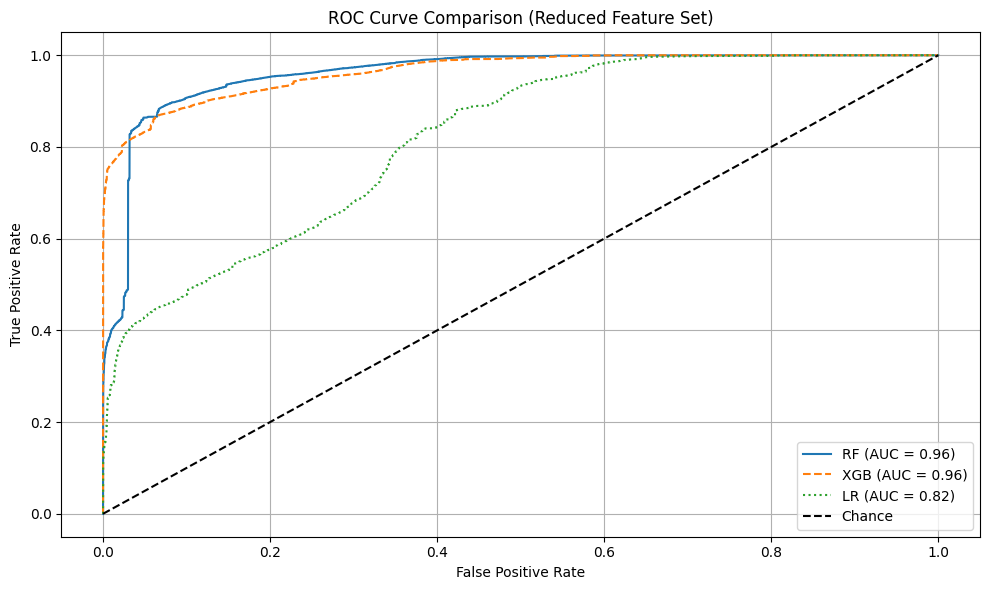

In [43]:
#45: ROC Curve for Classifier Comparison (Reduced Feature Set)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get probabilities
proba_rf = rf_reduced.predict_proba(X_test_selected)[:, 1]
proba_xgb = xgb_model_reduced.predict_proba(X_test_selected)[:, 1]
proba_log = log_model_reduced.predict_proba(X_test_selected)[:, 1]

# Compute ROC curves
fpr_rf, tpr_rf, _ = roc_curve(y_test_final, proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test_final, proba_xgb)
fpr_log, tpr_log, _ = roc_curve(y_test_final, proba_log)

# Plot ROC
plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, label=f'RF (AUC = {auc(fpr_rf, tpr_rf):.2f})', linestyle='-')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGB (AUC = {auc(fpr_xgb, tpr_xgb):.2f})', linestyle='--')
plt.plot(fpr_log, tpr_log, label=f'LR (AUC = {auc(fpr_log, tpr_log):.2f})', linestyle=':')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')

plt.title('ROC Curve Comparison (Reduced Feature Set)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()